# Importing Libraries

In [ ]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

## Rating Dataset

In [ ]:
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Movie Dataset

In [ ]:
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Merging the dataset

In [ ]:
data = pd.merge(ratings, movies, on='movieId')
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


## Creating Sparse Matrix

In [ ]:
user_item_matrix = data.pivot(index='userId', columns='movieId', values='rating').fillna(0)
matrix = csr_matrix(user_item_matrix.values)

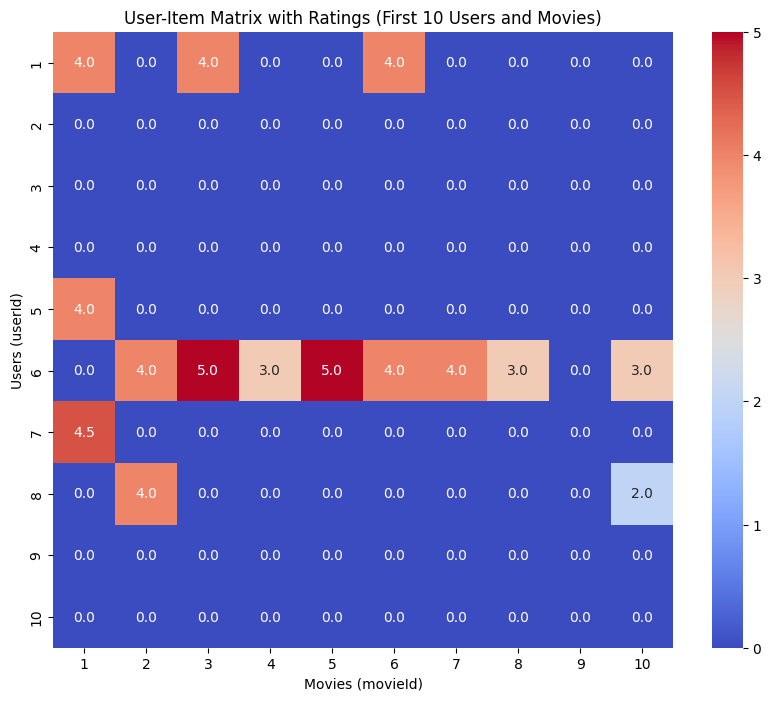

In [ ]:
subset_user_item_matrix = user_item_matrix.iloc[:10, :10]

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    subset_user_item_matrix,
    annot=True,
    fmt=".1f",
    cmap="coolwarm",
    cbar=True,
    xticklabels=True,
    yticklabels=True
)

plt.title("User-Item Matrix with Ratings (First 10 Users and Movies)")
plt.xlabel("Movies (movieId)")
plt.ylabel("Users (userId)")

plt.show()

## Training the Models

In [ ]:
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
item_user_matrix = user_item_matrix.T
item_user_sparse = csr_matrix(item_user_matrix.values)

movie_model = NearestNeighbors(metric='cosine', algorithm='brute')
movie_model.fit(item_user_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

### **Explanation**

This creates an instance of the `NearestNeighbors` class from `scikit-learn`, which is used to find the nearest neighbors (similar users or items) based on a specified distance metric.

### **Hyder Parameters**

1. **`metric='cosine'`**:
   - Specifies the **distance metric** used to measure similarity between data points.
   - In this case, the `cosine` metric calculates the **cosine similarity** between vectors.
   - **Cosine similarity** measures the cosine of the angle between two vectors. It focuses on the orientation (or direction) of the vectors rather than their magnitude, which makes it ideal for sparse data like user ratings.

   **Formula for Cosine Similarity**:
   $\text{cosine_similarity}(A, B) = \frac{A \cdot B}{||A|| \times ||B||}$

   - `A` and `B` are the vectors being compared.
   - `A · B`: Dot product of the two vectors.
   - `||A||` and `||B||`: Magnitudes (norms) of the vectors.

   - **Interpretation**:
     - `1.0`: Vectors are identical in direction (most similar).
     - `0.0`: Vectors are orthogonal (completely dissimilar).
     - Negative values: Opposite direction (rare in collaborative filtering).

2. **`algorithm='brute'`**:
   - Specifies the algorithm used to compute nearest neighbors.
   - `brute` performs an exhaustive search by comparing each point to every other point in the dataset.

   **Why Use `brute`?**
   - Efficient for small to medium datasets or when using a custom distance metric like `cosine`.
   - Alternative algorithms (`ball_tree`, `kd_tree`, `auto`) are more efficient for specific distance metrics like Euclidean but aren't optimized for `cosine`.

## Printing the recommendations

In [ ]:
def recommend_movies_for_movie_id(movie_id, n_recommendations=10):
    try:
        movie_idx = movies[movies['movieId'] == movie_id].index[0]

        distances, indices = movie_model.kneighbors(item_user_matrix.iloc[movie_idx].values.reshape(1, -1), n_neighbors=n_recommendations+1)

        recommended_movie_indices = indices.flatten()[1:]
        recommendations = movies.iloc[recommended_movie_indices]['title'].values

        print(f"Since you watched movie ID {movie_id} ('{movies.loc[movie_idx, 'title']}'):")
        for movie in recommendations:
            print(movie)
    except IndexError:
        print(f"Movie ID {movie_id} not found in the dataset.")

In [ ]:
def recommend_movies_for_user(user_id, n_recommendations=10):
    if user_id not in user_item_matrix.index:
        print(f"User ID {user_id} not found in the dataset.")
        return

    user_vector = matrix[user_id - 1]

    distances, indices = model.kneighbors(user_vector, n_neighbors=n_recommendations+1)

    similar_users = indices.flatten()[1:]

    similar_users_ratings = user_item_matrix.iloc[similar_users].mean(axis=0)
    user_ratings = user_item_matrix.loc[user_id]

    recommendations = similar_users_ratings[user_ratings == 0].sort_values(ascending=False).head(n_recommendations)
    recommended_movie_ids = recommendations.index
    recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]['title'].values

    print(f"Recommendations for User {user_id}:")
    for movie in recommended_movies:
        print(movie)

In [ ]:
recommend_movies_for_movie_id(10, n_recommendations=10)
print("\n")
recommend_movies_for_user(60, n_recommendations=10)

Since you watched movie ID 10 ('GoldenEye (1995)'):
Die Hard: With a Vengeance (1995)
True Lies (1994)
Clear and Present Danger (1994)
Speed (1994)
Batman (1989)
Stargate (1994)
Jurassic Park (1993)
Batman Forever (1995)
Mission: Impossible (1996)
Terminator 2: Judgment Day (1991)


Recommendations for User 60:
Star Wars: Episode IV - A New Hope (1977)
Pulp Fiction (1994)
Silence of the Lambs, The (1991)
One Flew Over the Cuckoo's Nest (1975)
Godfather: Part II, The (1974)
American History X (1998)
Fight Club (1999)
Lord of the Rings: The Two Towers, The (2002)
Departed, The (2006)
Inception (2010)
